In [18]:
import django, sys, os, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from scipy.sparse import coo_matrix, find
from sklearn.manifold import TSNE

from scoping.models import *
from tmv_app.models import *

import matplotlib
matplotlib.rcParams["figure.figsize"] = [7.2,4.5]
matplotlib.rcParams['axes.labelsize'] = 7 
matplotlib.rcParams['xtick.labelsize'] = 5
matplotlib.rcParams['ytick.labelsize'] = 5 

run_id = 758

In [2]:
db_matrix = DocTopic.objects.filter(run_id=run_id,score__gt=0.01)
docs = set(db_matrix.values_list('doc__id',flat=True))

len(docs)

277915

In [6]:
s_docs = random.sample(docs,10000)

In [7]:
column = 'term_id'
column = 'doc_id'

stat = RunStats.objects.get(pk=run_id)

db_matrix = DocTopic.objects.filter(
    run_id=run_id,
    score__gt=0.01,
    doc__id__in=s_docs
)



from scipy.sparse import *

vs = list(db_matrix.values('score',column,'topic_id'))

c_ind = np.array(db_matrix.values_list(column,flat=True).order_by(column).distinct())
r_ind = np.array(db_matrix.values_list('topic_id',flat=True).order_by('topic_id').distinct())

d = [x['score'] for x in vs]


c = [int(np.where(c_ind==x[column])[0]) for x in vs]
r = [int(np.where(r_ind==x['topic_id'])[0]) for x in vs]

m = csr_matrix((d,(r,c)),shape=(len(r_ind),len(c_ind)))

m = csr_matrix((d,(c,r)),shape=(len(c_ind),len(r_ind)))

print(db_matrix.count())

31723


In [8]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=50000)
tsne_results = tsne.fit_transform(m.toarray())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.412s...
[t-SNE] Computed neighbors for 10000 samples in 24.800s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.009344
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.216347
[t-SNE] Error after 34300 iterations: 1.447317


## Urban (blue), and Buildings (red) are close together 

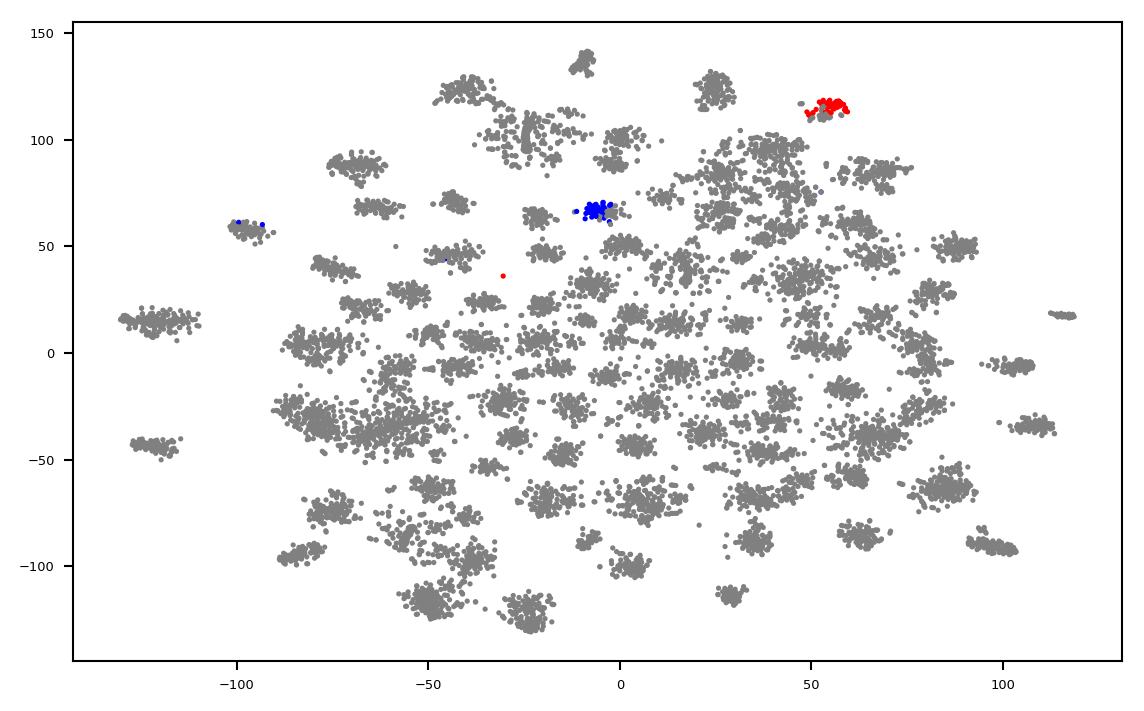

In [26]:


cmap = {
    1: "#66c2a5",
    2: "#fc8d62",
    3: "#8da0cb"
}

cs = []
sizes = []
xs = []
ys = []


fig = plt.figure(dpi=188)

build = list(DocTopic.objects.filter(
    topic__id=125029,doc__id__in=s_docs
).order_by('-score')[:50].values_list('doc__id',flat=True))

urban = list(DocTopic.objects.filter(
    topic__id=124998,doc__id__in=s_docs
).order_by('-score')[:50].values_list('doc__id',flat=True))

ubs = list(DocTopic.objects.filter(
    topic__id=124998,doc__id__in=s_docs
).order_by('-score')[:50].values_list('doc__id',flat=True))


#for i,t in enumerate(Doc.objects.filter(id__in=c_ind)):
for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    #if x > -7 and x < -5 and y > 4 and y < 6:
    if x>-10000000:
        #if hasattr(t,'wosarticle'):
        #    if t.wosarticle.tc is not None:
        #        if t.wosarticle.tc > 5000:
        #            plt.text(x,y,t.title,fontsize=5)
        #plt.text(x,y,t.title,fontsize=7)
        if did in build:
            cs.append("red")
        elif did in urban:
            cs.append("blue")
        else:
            cs.append("grey")
        #cs.append(cmap[t.primary_wg])
        #sizes.append(t.score)
        xs.append(x)
        ys.append(y)

plt.scatter(
    xs,
    ys,
    s=1,
    #s=sizes,
    c=cs,
)
plt.show()

## Clusters are mixtures of disciplines, but disciplines congregate in broad areas of the graph

This indicates that the distance **between** clusters is also telling us something interesting

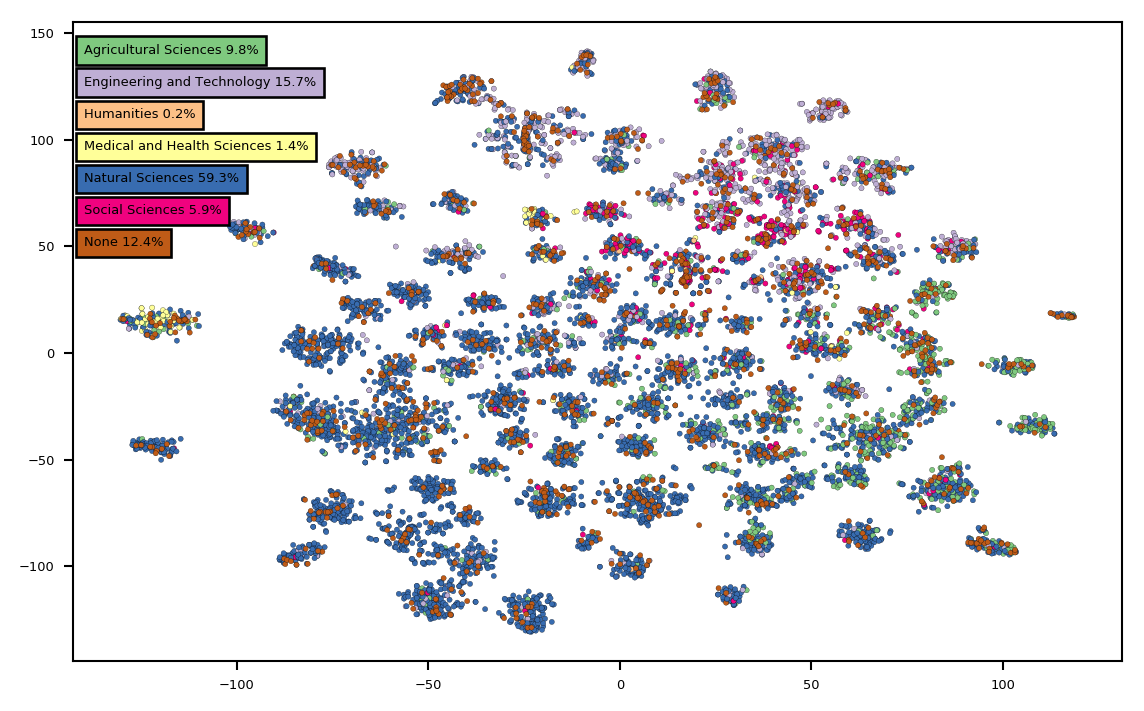

In [52]:
cs = []
sizes = []
xs = []
ys = []


fig = plt.figure(dpi=188)

colors = ['#b3e2cd','#fdcdac','#cbd5e8','#f4cae4','#e6f5c9','#fff2ae']
colors = ['#b3e2cd','#fdcdac','#cbd5e8','#f4cae4','#e6f5c9','#fff2ae','#f1e2cc']
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#bf5b17']
oecd_cats = list(Doc.objects.filter(id__in=s_docs).distinct('wc__oecd').values('wc__oecd'))
for i,c in enumerate(oecd_cats):
    c['docs'] = list(Doc.objects.filter(id__in=s_docs,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
    c['color'] = colors[i]


#for i,t in enumerate(Doc.objects.filter(id__in=c_ind)):
for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    col = "grey"
    for c in oecd_cats:
        if did in c['docs']:
            col = c['color']
    cs.append(col)
    xs.append(x)
    ys.append(y)
        

plt.scatter(
    xs,
    ys,
    s=4,
    #s=sizes,
    linewidth=0.1,
    c=cs,
    edgecolor='k'
)
for i,c in enumerate(oecd_cats):
    plt.text(
        -140,
        140-i*15,
        "{} {:.1%}".format(c['wc__oecd'],len(c['docs'])/10000),
        fontsize=5,
        bbox={
            'facecolor': c['color'],
            'pad': 3
        }
    )
plt.show()

## Not many documents in the sample were cited by IPCC, but reinforce the sto

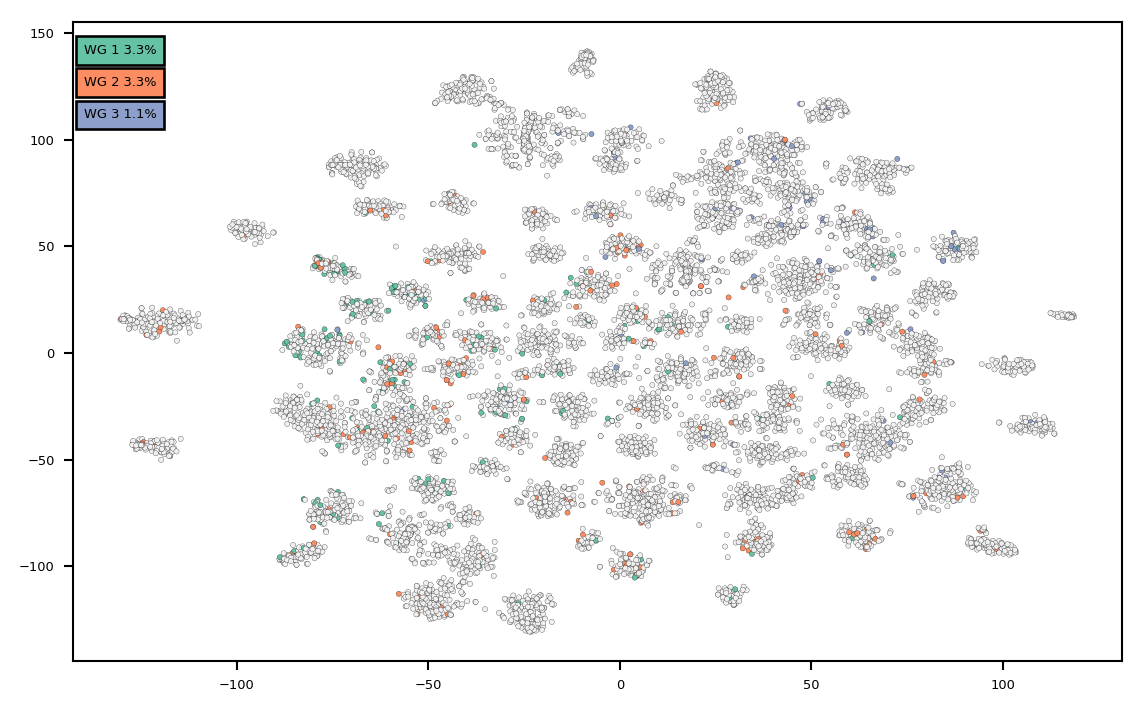

In [64]:
colors=["#66c2a5","#fc8d62","#8da0cb"]

cs = []
sizes = []
xs = []
ys = []
fig = plt.figure(dpi=188)

wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
for i,c in enumerate(wgs):
    c['docs'] = list(Doc.objects.filter(
        id__in=s_docs,ipccref__wg__wg=c['wg']
    ).values_list('id',flat=True))
    c['color'] = colors[i]

    
for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    col = "#F0F0F0"
    for c in wgs:
        if did in c['docs']:
            col = c['color']
    cs.append(col)
    xs.append(x)
    ys.append(y)
        

plt.scatter(
    xs,
    ys,
    s=4,
    #s=sizes,
    linewidth=0.1,
    c=cs,
    edgecolor='k'
)
for i,c in enumerate(wgs):
    plt.text(
        -140,
        140-i*15,
        "WG {} {:.1%}".format(c['wg'],len(c['docs'])/10000),
        fontsize=5,
        bbox={
            'facecolor': c['color'],
            'pad': 3
        }
    )
plt.show()

[{'color': '#66c2a5',
  'docs': [417875,
   122098,
   693811,
   184102,
   576764,
   197831,
   553771,
   153694,
   638726,
   685301,
   275369,
   666220,
   391163,
   705149,
   364594,
   718845,
   420451,
   489910,
   526794,
   98213,
   324232,
   529463,
   705149,
   300584,
   430669,
   386389,
   498689,
   665145,
   300966,
   15671,
   696,
   78574,
   528367,
   297533,
   529463,
   14426,
   300584,
   565365,
   665349,
   15946,
   197831,
   52749,
   199095,
   37775,
   271552,
   638726,
   666220,
   571094,
   548069,
   147829,
   123465,
   699403,
   529411,
   430669,
   704158,
   386389,
   677884,
   442360,
   652107,
   452346,
   548069,
   640025,
   537770,
   713300,
   612806,
   403939,
   427983,
   602673,
   425295,
   711784,
   380138,
   60634,
   338324,
   446214,
   552977,
   673445,
   48738,
   585066,
   734138,
   383213,
   17212,
   733967,
   276008,
   327250,
   78574,
   48738,
   417875,
   102455,
   446321,
   147